In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc


### We are defining some functions for preprocessing, cleaning and data structuring purposes

In [16]:
def clean_text(text):
    ''' 
    Some basic text cleaning phases this function should be applied to the text column
    of the data
    '''
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    # tokenize the text
    #text = text.split()
    return(text)

def evaluate_roc_probs(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    
def apply_cleaning(X_train):
    '''
    With this fonction we apply the clean_text function to the text column of the data
    and it gives as output the cleaned data for each row of the text column
    '''
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):
    ''''
    No need to explain this function because we gonna use it in the pipeline automatically this function
    used to add tf-idfs columns to the data but I used this to play around with the data and see the
    results of the tfidf vectorizer
    '''

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):
    '''
    I captured some differences between the parameters of the GridsearchCV output
    to standardize it and make it easy to be used later on the project.
    '''
    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

### Importing the train data and checking if the labels are distributed equally. 

<AxesSubplot: xlabel='labels'>

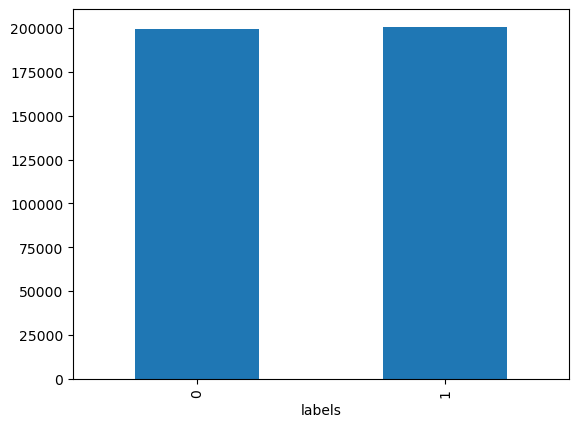

In [3]:
train = pd.read_csv('train_data_400k_randomsample.csv')
train["labels"].groupby(train["labels"]).count().plot(kind="bar")

##### To find the best hyperparameter settings we have to do a hyperparameter tunning with whether random search or gridsearch cv. Random search is usually fits best for the big datasets where trying all parameter combinations with cross validation is comnputationally expensive and time consuming. Eventhough random search don't always ensure the best hyperparameter combination. So I decided to randomly sample 400k of data from all dataset and applied a batched hyperparameter tunning with the hope of well generalization. For computational issues SVC has been trained with 400k of data with 4 batches of 100k because of long computational hardness and saving the each process so in case of any crash we can continue from the batch where we left off. 

In [33]:
# What this cell does is first subsampling the data to certain batches then doing hyperparameter tunning with GridsearchCV main reason for batching is that training all data 
# which is already huge gets more huge with tf-idf feature so the bigger the data it takes more time to train and tune the model so I decided to split the data into batches
# then taking the mean of each batch results to get the final results of the model. However slicing the data and taking the mean value of accuracy of all batches is good idea for
# generalization but when the sliced data is too small then hyperparameter setting for the small data is not good for the whole data so it is better to be careful about generalization. 

# Split the data into multiple slices

train["sentences"] = apply_cleaning(train["sentences"])

slices = [train[:400000]]

# Define the pipeline with normalization
pipeline_without_norm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

# Define the hyperparameters to tune for each pipeline
parameters_without_norm = {
    'tfidf__max_features': [5000],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf']
}

dfs = []

for i, slice in enumerate(slices):
    print("Slice: ", i+1, str(len(slice)))
    # Split the current slice into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(slice["sentences"], slice["labels"], test_size=0.1)
    
    # Create a GridSearchCV object for each pipeline
    grid_search_without_norm = GridSearchCV(pipeline_without_norm, parameters_without_norm, cv=3, verbose=3)

    with parallel_backend(backend="multiprocessing", n_jobs=-1):
        # Fit the GridSearchCV object on the training data
        grid_search_without_norm.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = grid_search_without_norm.predict(X_test)

    # Calculate the accuracy score for the current slice
    score = accuracy_score(y_test, y_pred)

    # Print the accuracy score and best hyperparameters for the current slice
    print("Accuracy score: ", score)
    print("Best hyperparameters: ", grid_search_without_norm.best_params_)
    print("Best accuracy score: ", grid_search_without_norm.best_score_)

    #store it in a dataframe
    df = pd.DataFrame(list(zip(grid_search_without_norm.cv_results_['params'], grid_search_without_norm.cv_results_['mean_test_score'])), columns=['params', 'mean_test_score of batch '+str(i)])
    df.to_csv('grid_search_results20k_batch'+str(i)+'.csv')
    dfs.append(df)

dfs = pd.concat(dfs, axis=0, ignore_index=True)
dfs["params"] = dfs["params"].apply(lambda x: dict2text(x))
dfs = dfs.groupby(['params']).mean().to_csv('grid_search_results400k.csv')
pd.DataFrame(zip(dfs["params"].values,dfs.mean(axis=0)),columns=['params','mean_test_score']).sort_values(by='mean_test_score',ascending=False).to_csv('grid_search_results400k_no_rbfgamma_setting_.csv')

##### But Linear SVC method has been trained with one batch of 400k due to time efficient computational abilities. 

In [30]:
# What this cell does is first subsampling the data to certain batches then doing hyperparameter tunning with GridsearchCV main reason for batching is that training all data 
# which is already huge gets more huge with tf-idf feature so the bigger the data it takes more time to train and tune the model so I decided to split the data into batches
# then taking the mean of each batch results to get the final results of the model. However slicing the data and taking the mean value of accuracy of all batches is good idea for
# generalization but when the sliced data is too small then hyperparameter setting for the small data is not good for the whole data so it is better to be careful about generalization. 

# Split the data into multiple slices

# train["sentences"] = apply_cleaning(train["sentences"])

slices = [train[:400000]]

# Define the pipeline with normalization
pipeline_without_norm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svc', LinearSVC())
])

duals = [True, False]
penaltys = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
all_params = list(product(duals, penaltys, losses))
filtered_params = [{'dual': [dual], 'penalty' : [penalty], 'loss': [loss]}
                   for dual, penalty, loss in all_params
                   if not (penalty == 'l1' and loss == 'hinge') 
                   and not ((penalty == 'l1' and loss == 'squared_hinge' and dual is True))
                  and not ((penalty == 'l2' and loss == 'hinge' and dual is False))]

# Define the hyperparameters to tune for each pipeline
c=[0.1, 1, 10]
duals = [True, False]
penaltys = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
all_params = list(product(duals, penaltys, losses,c))
filtered_params = [{'svc__dual': [dual], 'svc__penalty' : [penalty], 'svc__loss': [loss], 'svc__C':[C]}
                   for dual, penalty, loss, C in all_params
                   if not (penalty == 'l1' and loss == 'hinge') 
                   and not ((penalty == 'l1' and loss == 'squared_hinge' and dual is True))
                   and not ((penalty == 'l2' and loss == 'hinge' and dual is False))]

dfs = []

for i, slice in enumerate(slices):
    print("Slice: ", i+1, str(len(slice)))
    # Split the current slice into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(slice["sentences"], slice["labels"], test_size=0.1)
    
    # Create a GridSearchCV object for each pipeline
    grid_search = GridSearchCV(pipeline_without_norm, filtered_params, cv=3, verbose=3)

    with parallel_backend(backend="multiprocessing", n_jobs=-1):
        # Fit the GridSearchCV object on the training data
        grid_search.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = grid_search.predict(X_test)

    # Calculate the accuracy score for the current slice
    score = accuracy_score(y_test, y_pred)

    # Print the accuracy score and best hyperparameters for the current slice
    print("Accuracy score: ", score)
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best accuracy score: ", grid_search.best_score_)

    #store it in a dataframe
    df = pd.DataFrame(list(zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'])), columns=['params', 'mean_test_score of batch '+str(i)])
    df.to_csv('grid_search_results20k_batch'+str(i)+'.csv')
    dfs.append(df)

dfs = pd.concat(dfs, axis=0, ignore_index=True)
dfs["params"] = dfs["params"].apply(lambda x: dict2text(x))
dfs = dfs.groupby(['params']).mean().to_csv('grid_search_results400k_linearsvc.csv')

Slice:  1 400000
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.894 total time=  22.9s
[CV 2/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.894 total time=  24.0s
[CV 3/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.894 total time=  23.9s
[CV 2/3] END svc__C=0.1, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.899 total time=  25.2s
[CV 1/3] END svc__C=0.1, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.898 total time=  25.9s
[CV 3/3] END svc__C=0.1, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.899 total time=  26.2s
[CV 1/3] END svc__C=1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.897 total time=  39.4s
[CV 2/3] END svc__C=1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.899 total time=  39.8s
[CV 3/3] END svc__C=1, svc__dual=True, svc__lo

/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END svc__C=10, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.884 total time= 1.6min
[CV 1/3] END svc__C=10, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.883 total time= 1.7min
[CV 2/3] END svc__C=10, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.883 total time= 1.8min
[CV 1/3] END svc__C=1, svc__dual=False, svc__loss=squared_hinge, svc__penalty=l1;, score=0.895 total time= 1.0min
[CV 2/3] END svc__C=1, svc__dual=False, svc__loss=squared_hinge, svc__penalty=l1;, score=0.896 total time= 1.1min
[CV 3/3] END svc__C=10, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.873 total time= 1.5min
[CV 1/3] END svc__C=10, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.872 total time= 1.6min
[CV 3/3] END svc__C=1, svc__dual=False, svc__loss=squared_hinge, svc__penalty=l1;, score=0.896 total time= 1.4min
[CV 1/3] END svc__C=0.1, svc__dual=False, svc__loss=squared_hinge, svc__penalty=l2;, score=0.898 total time=  40

#### After simple concetanation and merging phases all the parameters and cv scores are contained in one csv document and saved to the local disc. The model which yields best accuracy score is selected for the whole evaluation. 

In [4]:
df = pd.read_csv("hyperparametertunning_results_all.csv")
df[df["mean_test_score"] == df["mean_test_score"].max()]["params"][0]

'svc__C=0.1 svc__dual=False svc__loss=squared_hinge svc__penalty=l2'

#### After selecting the best parameters our model with 1 milion train data and 100k test data being evaluated. And confusion matrix has been produced. 

In [4]:
train = pd.read_csv("train_data_400k_randomsample.csv")
train["sentences"] = apply_cleaning(train["sentences"])
test = pd.read_csv(("test_data_44k.csv"))
test["sentences"] = apply_cleaning(test["sentences"])

In [5]:
#train the model with best hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svc', LinearSVC(dual=False, penalty='l2', loss='squared_hinge', C=0.1, verbose=3)),
])

pipeline.fit(train["sentences"], train["labels"])

y_pred = pipeline.predict(test["sentences"])
# pd.DataFrame(y_pred).to_csv("y_pred_tf-idfsvm.csv")

accuracy_score = accuracy_score(test["labels"], y_pred)
f1_score = f1_score(test["labels"], y_pred)
roc_auc_score = roc_auc_score(test["labels"], y_pred)
precision_score = precision_score(test["labels"], y_pred)
recall_score = recall_score(test["labels"], y_pred)

print("Accuracy score: ", accuracy_score)
print("F1 score: ", f1_score)
print("ROC AUC score: ", roc_auc_score)
print("Precision score: ", precision_score)
print("Recall score: ", recall_score)


[LibLinear]iter  1 act 2.425e+04 pre 2.317e+04 delta 2.089e+01 f 4.000e+04 |g| 3.183e+03 CG   6
iter  2 act 1.991e+03 pre 1.679e+03 delta 2.089e+01 f 1.575e+04 |g| 5.459e+02 CG  10
iter  3 act 3.465e+02 pre 3.057e+02 delta 2.089e+01 f 1.376e+04 |g| 3.069e+02 CG  10
iter  4 act 3.071e+01 pre 2.921e+01 delta 2.089e+01 f 1.341e+04 |g| 1.002e+02 CG  10
iter  5 act 1.263e+00 pre 1.259e+00 delta 2.089e+01 f 1.338e+04 |g| 1.639e+01 CG  12
iter  6 act 2.822e-02 pre 2.819e-02 delta 2.089e+01 f 1.338e+04 |g| 1.156e+00 CG  15
Accuracy score:  0.8964772727272727
F1 score:  0.8964137084119801
ROC AUC score:  0.896480667864085
Precision score:  0.8948873955684707
Recall score:  0.8979452366850426


#### Obtain predicted probabilities for ROC AUC

In [45]:
from sklearn.calibration import CalibratedClassifierCV

# Train the model with best hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svc', LinearSVC(dual=False, penalty='l2', loss='squared_hinge', C=0.1)),
])

pipeline.fit(train["sentences"], train["labels"])

# Vectorize the training data
X_train = pipeline.named_steps['tfidf'].transform(train["sentences"])

# Train the model with best hyperparameters
calibrated_model = CalibratedClassifierCV(pipeline.named_steps['svc'])
calibrated_model.fit(X_train, train["labels"])

X_test = pipeline.named_steps['tfidf'].transform(test["sentences"])
# Predict probabilities for the test data
y_pred_proba = calibrated_model.predict_proba(X_test)

# Obtain the predicted class labels
y_pred = calibrated_model.predict(X_test)


AUC: 0.9598


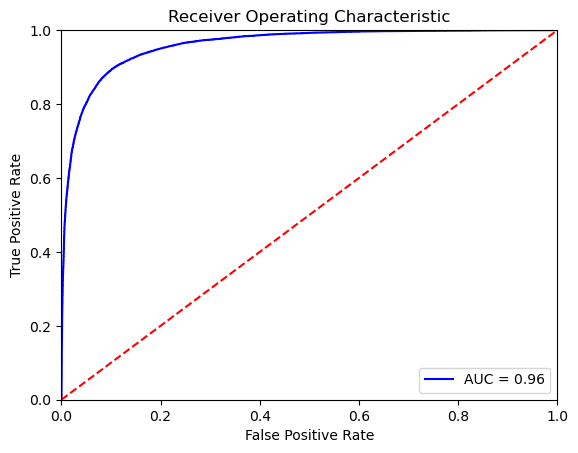

In [50]:
def evaluate_roc_probs(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true),)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Evaluate ROC curve
evaluate_roc_probs(y_pred_proba[:, 1], test["labels"].values)

#### Error Analysis

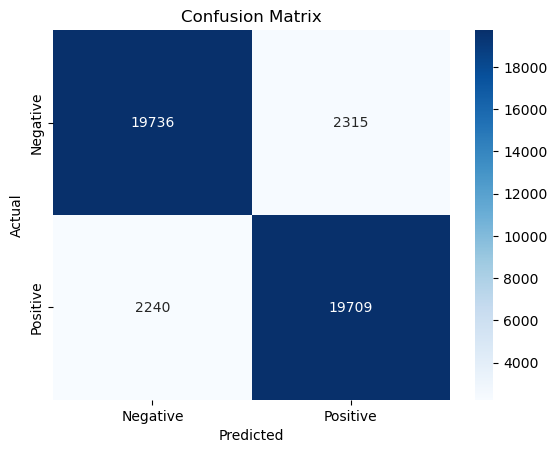

In [6]:
#Show confusion matrix
cm = confusion_matrix(test["labels"], y_pred)
cm = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<AxesSubplot: xlabel='labels'>

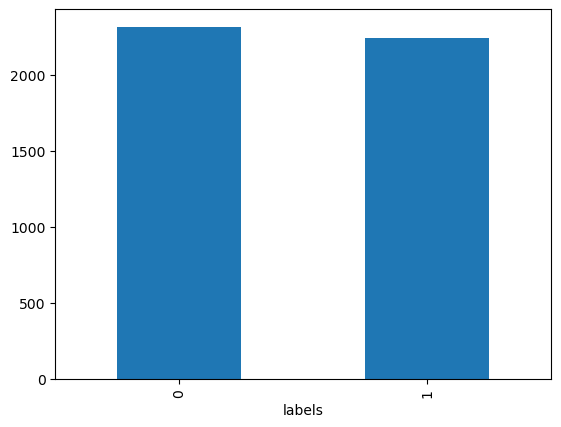

In [10]:
test = pd.read_csv(("test_data_44k.csv"))
test["y_pred"] = y_pred
test[test["labels"] != test["y_pred"]].groupby('labels').count()["sentences"].plot(kind="bar")

In [8]:
# Select the 5 random observations from the test set where model failed to predict the label correctly

pd.set_option('display.max_colwidth', None)
# test[test["labels"] != test["y_pred"]].sample(5)
indices = [27443, 29215, 14827 ,18809 ,12847]
test[test.index.isin(indices)]

,sentences,labels,y_pred
12847,"a good book: this book really hit the mark with the right balance of theory and practical application. i've waded through more than a few technical books on tube radio theory and restoration, and this one, though not as detailed as a textbook, is clearly the place to start.however, the section on troubleshooting was extremely limited. experience indicates that after following the steps recommended in the book between 10 and 20 percent of restored radios will still have some type of problem. most individuals learning the process for repairing tube radios will be seeking practical guidance for identifying possible sources of these problems and their potential solutions. maybe troubleshooting will be the subject of mr. mcwhorter's next book.",1,0
14827,"here is just a sample!! check it out!!: i love this album and pray that someone contacts me so that i can get a copy of the cd or even tape! amazon...please get this so that all of us who would like a copy can get it! until then...here is ""feel like going on"" the song![...]",1,0
18809,"still in the box: i don't really know how the product is. after reading more detailed information included with the product, it says not recommended for the pool because the clorine could effect/shorten the product life. it seems that the ad shows the coolaroo shade being used next to the pool. and that's what we bought it for. not sure what to do with them now - still siting in the box next to the door gathering dust.... oh, well. i'm sure its a great product, just not for us.",0,1
27443,"leaves the readers hungry for more.: it's weird really how i got so into this book. one of my friends who just so happened read the book was begging me to read it. now, don't get me wrong i love fantasy stories especially ones that are about these blood suckers but after hearing my friend's summary of it i don't know i just felt uninterested.pffft...boy was i glad my friend's the persisting type. she practically lunged the book at me. so as to not annoy her more, i read her copy of the book and i found myself entralled by it. i could not stop reading it!after finishing it i felt saddened that it was finished. i wanted more! i wanted to know what happened next.i gave the book back to my friend and straight away got myself a copy of twilight. it's really that good. i love it.trust me no matter how 'off' the summary might seem like you would not feel dissatisfied by its contents.",1,0
29215,"emotionally-distant author: for a memoir, the author is very removed from the experiences she writes about. she conveys little if any emotion about what must have been a very lonely and often frightening existance (especially given her age) in a strange land with a mad and eventually abusive husband, a young child who was often extremely sick and with the responsibilites of running a hacienda. although her writing is beautiful at times, the author never really connected with me.",0,1


 It seems tf-idf SVM can capture most of the reviews correctly but it seems from the errors it cannot perfectly capture the the meaning of the reviews. Whenever there are some words that are associated with negative label used in a positive rating SVM fail to understand the overall context. 
 
 SVM alignes the data points based on their sparse tf-idf matrix and creates a hyperplane to classify different documents and some of the words which are labeled with negative sentiments are drafting the position of a positive review into negative ones. Tf-idf SVM works well when data has clear and linear seperability and the task becomes harder when reviews become ironic or the context is positive but words are negative. 
 
 To overcome this problem BERT transformers would be a better option because they are better capturing the context and semantics. BERT captures the semantic meaning and contextual information of words by considering their surrounding words.